# Escalonamento de características e taxa de aprendizado

## Objetivos
Com este código você irá:
- Utilizar as rotinas de regressão linear múltipla desenvolvidas no último código
- Rodar o Método do Gradiente num conjunto de dados com múltiplas características
- Explorar o impacto da escolha da *taxa de aprendizado alpha* no Método do Gradiente
- Melhorar a performance do gradiente realizando o *Escalonamento de características* chamado *Normalização Z-score*

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)  # reduz a precisão das numpy arrays na hora de dar print

# Definição do Problema

Usaremos um exemplo de motivação baseado no problema de estimar o preço de uma casa.

Os dados de treinamento contêm três exemplos com quatro características (size, bedrooms, floors e age).  Note que a primeira característica possui uma ordem de grandeza muito maior que as demais. Note também que os dados são diferentes daqueles usados no código anterior. De fato, nesse código iremos usar um conjunto de dados com mais amostras (100 casas). Esse conjunto de dados encontra-se num arquivo individual denominado dados_casas.txt

## Conjunto de dados:
| Size (sqft) | Number of Bedrooms  | Number of floors | Age of  Home | Price (1000s dollars)  |   
| ----------------| ------------------- |----------------- |--------------|----------------------- |  
| 952             | 2                   | 1                | 65           | 271.5                  |  
| 1244            | 3                   | 2                | 64           | 232                    |  
| 1947            | 3                   | 2                | 17           | 509.8                  |  
| ...             | ...                 | ...              | ...          | ...                    |


Você irá construir um modelo de regressão linear usando esses valores de tal forma que você também possa depois estimar o preço de outras casas. Por exemplo, um casa com 1200 sqft, 3 bedrooms, 1 floor, 40 years old.  



In [2]:
# Carregando os dados

file = open('dados_casas.txt') # As quatro primeiras colunas referem-se a características das casas.
                               # A quinta (última) coluna refere-se ao preço pelo qual tais casas foram negociadas
dados = np.loadtxt(file, delimiter=",") 

print(type(dados)) # observa-se que os dados já estão no formato de numpy arrays

print(dados[0:10,:])  # mostra as primeiras 10 amostras dos dados

X_train = dados[:,0:4]
y_train = dados[:,-1] # pega apenas a última coluna. Seria o mesmo que y = dados[:,4] 

print(X_train.shape)
print(y_train.shape)

X_caracteristicas = ['size(sqft)','bedrooms','floors','age']

<class 'numpy.ndarray'>
[[9.52e+02 2.00e+00 1.00e+00 6.50e+01 2.72e+02]
 [1.24e+03 3.00e+00 1.00e+00 6.40e+01 3.00e+02]
 [1.95e+03 3.00e+00 2.00e+00 1.70e+01 5.10e+02]
 [1.72e+03 3.00e+00 2.00e+00 4.20e+01 3.94e+02]
 [1.96e+03 3.00e+00 2.00e+00 1.50e+01 5.40e+02]
 [1.31e+03 2.00e+00 1.00e+00 1.40e+01 4.15e+02]
 [8.64e+02 2.00e+00 1.00e+00 6.60e+01 2.30e+02]
 [1.84e+03 3.00e+00 1.00e+00 1.70e+01 5.60e+02]
 [1.03e+03 3.00e+00 1.00e+00 4.30e+01 2.94e+02]
 [3.19e+03 4.00e+00 2.00e+00 8.70e+01 7.18e+02]]
(100, 4)
(100,)


Vamos visualizar o conjunto de dados e suas características plotando cada uma das características versus o tempo.

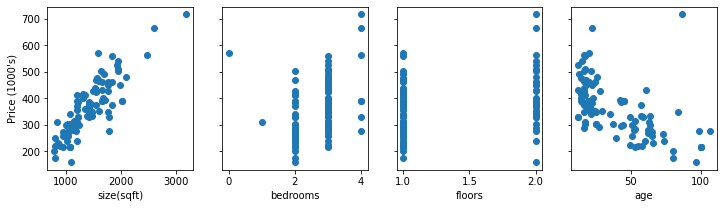

In [3]:
fig,ax=plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train)
    ax[i].set_xlabel(X_caracteristicas[i])
ax[0].set_ylabel("Price (1000's)")
plt.show()

Plotando cada característica versus o alvo y (no caso, o preço), conseguimos um indicativo de quais características possuem maior influência no preço. Como pode ser percebido, aumentar o tamanho (size) também aumenta o preço. Quartos e Andares não parecem ter um impacto tão grande no preço. Por fim, casas mais novas têm preços maiores em comparação com casas mais antigas.

## Revisitando o nosso código do Método do Gradiente

Abaixo nós estamos definindo novamente as 3 funções que implementam o Método do Gradiente (essas foram as funções desenvolvidas no último código).

In [4]:
def calcula_custo(X, y, w, b): 
    """
    Calcula o custo
    Args:
      X (ndarray (m,n)): Dados, contendo m exemplos com n características
      y (ndarray (m,)) : valores alvo
      w (ndarray (n,)) : parâmetros w do modelo  
      b (scalar)       : parâmetro b do modelo
      
    Retorna:
      custo (escalar): custo
    """
    m     = X.shape[0]
    custo = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = escalar (see np.dot)
        custo = custo + (f_wb_i - y[i])**2     # escalar
    custo = custo / (2 * m)                    # escalar    
    return custo

def calcula_gradiente(X, y, w, b): 
    """
    Calcula Gradiente para Regressão Linear
    Args:
      X (ndarray (m,n)): Dados, contendo m exemplos com n características
      y (ndarray (m,)) : valores alvo
      w (ndarray (n,)) : parâmetros w do modelo  
      b (scalar)       : parâmetro b do modelo
      
    Retorna:
      dj_dw (ndarray (n,)): O gradiente da função custo com relação aos parâmetros w. 
      dj_db (escalar):      O gradiente da função custo com relação ao parâmetro b. 
    """
    m,n = X.shape           #(número de exemplos, número de características)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                             
        erro = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + erro * X[i, j]    
        dj_db = dj_db + erro                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw

def metodo_do_gradiente(X, y, w_in, b_in, calcula_custo, calcula_gradiente, alpha, num_iters): 
    """
    Performa Método do Gradiente para aprender theta. Atualiza theta ao longo de  
    num_iters passos de iteração usando uma taxa de aprendizado alpha
    
    Args:
      X (ndarray (m,n))   : Dados, contendo m exemplos com n características
      y (ndarray (m,))    : valores alvo
      w_in (ndarray (n,)) : valores iniciais dos parâmetros w do modelo  
      b_in (escalar)      : valor inicial do parâmetro b do modelo
      calcula_custo       : função que calcula o custo
      calcula_gradiente   : função que calcula o gradiente
      alpha (float)       : taxa de aprendizado
      num_iters (int)     : Número de iterações para o método do gradiente
      
    Retorna:
      w (ndarray (n,)) : Valores atualizados para os parâmetros w
      b (scalar)       : Valores atualizado para o parâmetro b 
      """
    
    # Valores históricos
    J_history = []
    w = w_in
    b = b_in
    
    for i in range(num_iters):

        # Calcula o gradiente
        dj_db,dj_dw = calcula_gradiente(X, y, w, b)   ##None

        # Atualiza os parâmetros
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Salva o custo
        if i<100000:      # prevent resource exhaustion 
            J_history.append( calcula_custo(X, y, w, b))

        # Faz print de tempos em tempos
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteração {i:4d}: Custo {J_history[-1]:8.2f}   ")
        
    return w, b, J_history # retorna valores finais e históricos

<a name="toc_15456_5"></a>
## Abaixo nós testamos nossa implementação do Método do Gradiente para esse novo conjunto de dados, considerando um valor elevado para $\alpha$, $\alpha = 10 \times 10^{-7}$


Iteração    0: Custo 96598.21   
Iteração    1: Custo 131589.37   
Iteração    2: Custo 179465.09   
Iteração    3: Custo 244969.73   
Iteração    4: Custo 334594.59   
Iteração    5: Custo 457221.19   
Iteração    6: Custo 625001.40   
Iteração    7: Custo 854561.64   
Iteração    8: Custo 1168650.51   
Iteração    9: Custo 1598393.06   
b,w encontrados pelo método do gradiente: -0.00,[-0.96 -0.   -0.   -0.03] 


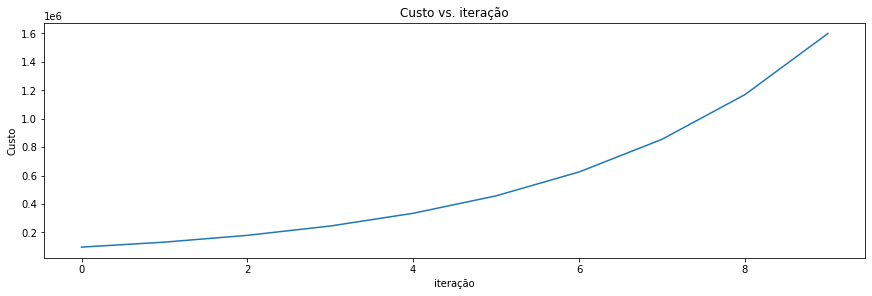

In [5]:
# inicializando parâmetros
initial_w = np.array([ 0.0,  0.0,  0.0,  0.0])
initial_b = 0.0
# parâmetros para rodar o Método do Gradiente:
iterations = 10
alpha      = 10e-7
# Rodando o Método do gradiente 
w_final, b_final, J_hist = metodo_do_gradiente(X_train, y_train, initial_w, initial_b,
                                                    calcula_custo, calcula_gradiente, 
                                                    alpha, iterations)
print(f"b,w encontrados pelo método do gradiente: {b_final:0.2f},{w_final} ")

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(J_hist)
ax.set_title("Custo vs. iteração")
ax.set_ylabel('Custo')         
ax.set_xlabel('iteração')    
plt.show()

A taxa de aprendizado parece estar muito grande. A solução não converge. O Custo está crescendo ao invés de diminuir.


## Agora considerando um valor menor, $\alpha = 1 \times 10^{-7}$


Iteração    0: Custo 44154.43   
Iteração    1: Custo 27679.69   
Iteração    2: Custo 17578.45   
Iteração    3: Custo 11385.01   
Iteração    4: Custo  7587.58   
Iteração    5: Custo  5259.23   
Iteração    6: Custo  3831.62   
Iteração    7: Custo  2956.29   
Iteração    8: Custo  2419.57   
Iteração    9: Custo  2090.48   
b,w encontrados pelo método do gradiente: 0.00,[2.31e-01 4.18e-04 2.12e-04 4.87e-03] 


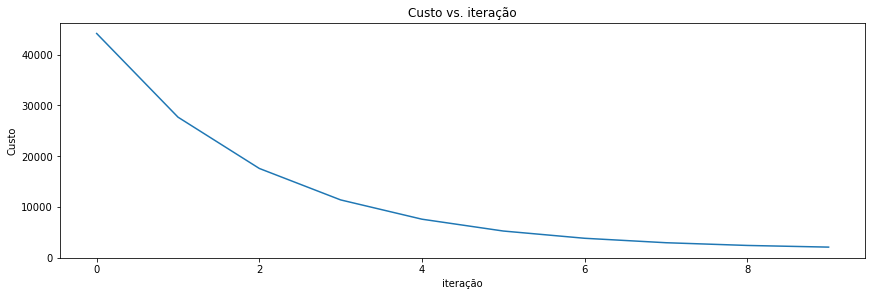

In [6]:
# inicializando parâmetros
initial_w = np.array([ 0.0,  0.0,  0.0,  0.0])
initial_b = 0.0
# parâmetros para rodar o Método do Gradiente:
iterations = 10
alpha      = 1e-7
# Rodando o Método do gradiente 
w_final, b_final, J_hist = metodo_do_gradiente(X_train, y_train, initial_w, initial_b,
                                                    calcula_custo, calcula_gradiente, 
                                                    alpha, iterations)
print(f"b,w encontrados pelo método do gradiente: {b_final:0.2f},{w_final} ")

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(J_hist)
ax.set_title("Custo vs. iteração")
ax.set_ylabel('Custo')         
ax.set_xlabel('iteração')    
plt.show()


O Custo está decrescendo ao longo das iterações. Isso significa que $\alpha$ não está muito grande para a função Custo como um todo.


## Testando um valor ainda menor, $\alpha = 0.1\times 10^{-7}$


Iteração    0: Custo 68042.86   
Iteração    1: Custo 65189.58   
Iteração    2: Custo 62458.78   
Iteração    3: Custo 59845.20   
Iteração    4: Custo 57343.80   
Iteração    5: Custo 54949.76   
Iteração    6: Custo 52658.49   
Iteração    7: Custo 50465.57   
Iteração    8: Custo 48366.77   
Iteração    9: Custo 46358.06   
b,w encontrados pelo método do gradiente: 0.00,[4.98e-02 9.08e-05 4.68e-05 1.12e-03] 


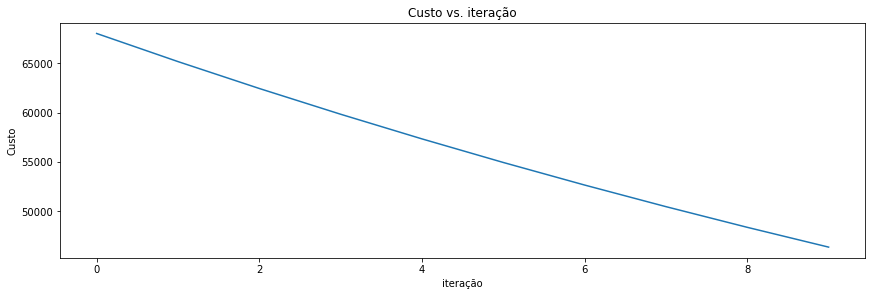

In [7]:
# inicializando parâmetros
initial_w = np.array([ 0.0,  0.0,  0.0,  0.0])
initial_b = 0.0
# parâmetros para rodar o Método do Gradiente:
iterations = 10
alpha      = 0.1e-7
# Rodando o Método do gradiente 
w_final, b_final, J_hist = metodo_do_gradiente(X_train, y_train, initial_w, initial_b,
                                                    calcula_custo, calcula_gradiente, 
                                                    alpha, iterations)
print(f"b,w encontrados pelo método do gradiente: {b_final:0.2f},{w_final} ")

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(J_hist)
ax.set_title("Custo vs. iteração")
ax.set_ylabel('Custo')         
ax.set_xlabel('iteração')    
plt.show()


O Custo está decrescendo ao longo das iterações. Isso significa que $\alpha$ não está muito grande. Entretanto, note que o custo encontra-se decaindo lentamente, o que indica um valor muito baixo para $\alpha$.

## Escalonamento de Características


Existem diferentes formas para se escalonar características: 
- Dividindo pelo máximo: Nesse caso, essencialmente divide-se uma característica pelo seu valor máximo. Numa situação mais geral, é possível utilizar tanto o valor máximo como o mínimo, fazendo-se (x-min)/(max-min).
- Normalização pela média: Nesse caso, faz-se (x-media(x))/(max-min)
- Normalização Z-score: Nesse caso, faz-se (x-media(x))/(desvio)

>**OBSERVAÇÃO IMPORTANTE:** Ao normalizar características, é importante armazenar (guardar) os valores usados na normalização, média e desvio padrão no caso da normalização Z-score, por exemplo. Isso porque, após o modelo ser estimado, nós frequentemente queremos usar ele para estimar o preço de casas que não foram usadas no processo de treinamento. Dada uma nova casa com características x, nós devemos primeiro normalizar x usando a média e o desvio padrão que foram previamente computados a partir dos dados de treinamento.

A função abaixo implementa a normalização Z-Score

In [8]:
def normalizacao_zscore(X):
    """
    Normaliza todas as colunas em X
    
    Argumentos:
      X (ndarray (m,n))     : Dados de entrada, m amostras (linhas), n características (colunas)
      
    Retorna:
      X_norm (ndarray (m,n)): Matriz X normalizada
      mu (ndarray (n,))     : média de cada característica
      sigma (ndarray (n,))  : desvio padrão de cada característica
    """
    # Encontrando a média de cada característica/coluna
    mu     = np.mean(X, axis=0)                 # mu terá shape (n,) ---> axis=0 indica que a operação será feita ao longo das linhas, para cada coluna
    # Encontrando o desvio padrão de cada característica/coluna
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # O comando abaixo subtrai a média mu de cada coluna para cada exemplo, e divide pelo desvio correspondente
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

#O que a nossa função faz pode ser feito usando a biblioteca Scikit learn, por meio dos comandos abaixo
#from sklearn.preprocessing import scale
#scale(X_orig, axis=0, with_mean=True, with_std=True, copy=True)

In [9]:
# Normalizando as características a partir da função normalizacao_zscore
X_norm, X_mu, X_sigma = normalizacao_zscore(X_train)
print(f"X_mu = {X_mu}, \nX_sigma = {X_sigma}")
print(f"Intervalo pico a pico por característica/coluna nos dados originais  :{np.ptp(X_train,axis=0)}")   
print(f"Intervalo pico a pico por característica/coluna nos dados escalonados:{np.ptp(X_norm,axis=0)}")

X_mu = [1.41e+03 2.71e+00 1.38e+00 3.86e+01], 
X_sigma = [412.17   0.65   0.49  25.79]
Intervalo pico a pico por característica/coluna nos dados originais  :[2.41e+03 4.00e+00 1.00e+00 9.50e+01]
Intervalo pico a pico por característica/coluna nos dados escalonados:[5.84 6.13 2.06 3.68]


Com a normalização, o intervalo pico a pico para cada característica é reduzido de uma ordem de grandeza de milhares para uma ordem de gradeza de poucas unidades.

Iteração    0: Custo 34611.46   
Iteração   20: Custo   242.12   
Iteração   40: Custo   220.05   
Iteração   60: Custo   219.72   
Iteração   80: Custo   219.71   
Iteração  100: Custo   219.71   
Iteração  120: Custo   219.71   
Iteração  140: Custo   219.71   
Iteração  160: Custo   219.71   
Iteração  180: Custo   219.71   
b,w encontrados pelo método do gradiente: 362.24,[110.61 -21.47 -32.66 -37.78] 


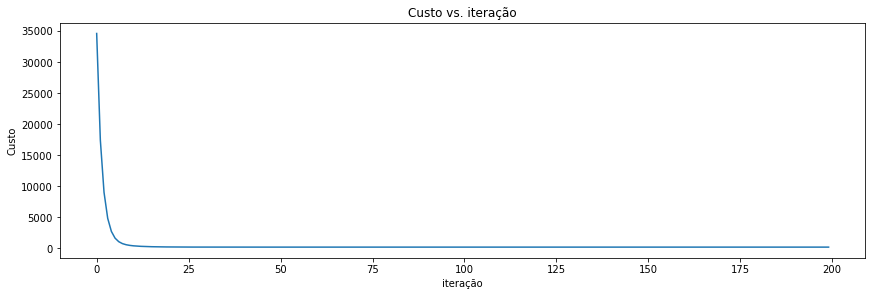

In [10]:
# inicializando parâmetros
initial_w = np.array([ 0.0,  0.0,  0.0,  0.0])
initial_b = 0.0

# parâmetros para rodar o Método do Gradiente:
iterations = 200
alpha      = 0.3
# Rodando o Método do gradiente 
w_norm, b_norm, J_hist = metodo_do_gradiente(X_norm, y_train, initial_w, initial_b,
                                                    calcula_custo, calcula_gradiente, 
                                                    alpha, iterations)
print(f"b,w encontrados pelo método do gradiente: {b_norm:0.2f},{w_norm} ")

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(J_hist)
ax.set_title("Custo vs. iteração")
ax.set_ylabel('Custo')         
ax.set_xlabel('iteração')    
plt.show()


As características escalonadas levam à resultados satisfatórios **muito mais rapidamente!**. Uma taxa de aprendizado de 0.1 ou 0.3 é geralmente um bom começo para regressão com características escalonadas.

Abaixo nós plotamos nossas previsões versus os valores alvo. Note, a previsão é feita usando as características normalizadas enquanto que o gráfico mostra os valores originais dessas características.

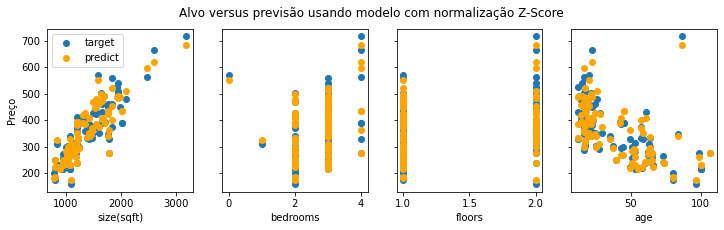

In [11]:
# realizando previsão usando características escalonadas
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_norm) + b_norm

# plotando alvo versus previsão    
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_caracteristicas[i])
    ax[i].scatter(X_train[:,i],yp,color='orange', label = 'predict')
ax[0].set_ylabel("Preço"); ax[0].legend();
fig.suptitle("Alvo versus previsão usando modelo com normalização Z-Score")
plt.show()

Os resultados parecem satisfatórios. Algumas observações importantes:
- Com múltiplas características, Nós não conseguimos mais ter um único plot contendo resultados versus características.
- Ao gerar o plot, as caraterísticas normalizadas foram usadas. Qualquer previsão usando os parâmetros aprendidos a partir dos dados de treinamento normalizados também devem ser previamente normalizados.

**Previsão**
Agora que temos um modelo, podemos utilizá-lo para realizar a previsão do valor de casas que não estavam presentes no conjunto de 100 amostras que usamos para treinar o modelo. Vamos estimar o preço de uma casa com 1200 sqft, 3 bedrooms, 1 floor, 40 years old. Lembre-se, você deve primeiramente normalizar os dados com a média e o desvio vindos dos dados de treinamento.

In [12]:
x_casa = np.array([1200, 3, 1, 40])
x_casa_norm = (x_casa - X_mu) / X_sigma
print(x_casa_norm)
y_casa = np.dot(x_casa_norm, w_norm) + b_norm
print(f" Preço estimado para uma casa com 1200 sqft, 3 bedrooms, 1 floor, 40 years old = ${y_casa*1000:0.0f}")

[-0.52  0.44 -0.78  0.05]
 Preço estimado para uma casa com 1200 sqft, 3 bedrooms, 1 floor, 40 years old = $318936



## Parabéns!

Com este código, você:
- utilizou as rotinas de regressão linear múltipla desenvolvidas em códigos anteriores
- explorou o impacto da taxa de aprendizado $\alpha$ na convergência do Método do Gradiente
- descobriu a importância do Escalonamento de Características usando a Normalização Z-Score para acelerar convergência

## Agradecimentos
Os dados foram obtidos da seguinte referência: [Ames Housing dataset](http://jse.amstat.org/v19n3/decock.pdf). Tais dados foram compilados por Dean De Cock.